In [107]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('default') # Make the graphs a bit prettier

plt.rcParams['figure.figsize'] = (12, 4)

#  Analisis exploratorio ultimos 6 meses año 2017

El analisis exploratorio que se presenta a continuacion tiene como fin determinar que feathers influyen en mayor medida a la hora de determinar el precio de un inmueble en Capital Federal y Gran Buenos Aires, asi como tambien encontrar datos curiosos en el data set.

In [2]:
sell_properati = pd.read_csv('../data/properati_full_month.csv',low_memory=False)

In [3]:
sell_properati.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 597228 entries, 0 to 597227
Data columns (total 31 columns):
country_name                  203235 non-null object
created_on                    597228 non-null object
currency                      499252 non-null object
description                   385325 non-null object
expenses                      28822 non-null object
extra                         164828 non-null object
floor                         81496 non-null float64
geonames_id                   503992 non-null float64
id                            220507 non-null object
image_thumbnail               579074 non-null object
lat                           476202 non-null float64
lat-lon                       476202 non-null object
lon                           476197 non-null float64
operation                     597228 non-null object
place_name                    597187 non-null object
place_with_parent_names       597228 non-null object
place_with_parent_names_l1    17272 non

Transformando el formato del feature created_on para manejarlo como fecha

In [4]:
sell_properati['created_on'] = sell_properati['created_on'].apply(lambda x : pd.to_datetime(x))

In [5]:
sell_properati['year'] = sell_properati['created_on'].apply(lambda x : x.year)

In [6]:
sell_properati.year.unique()

array([2017, 2014, 2016, 2015, 2013])

In [7]:
sell_properati['year_month'] = sell_properati.created_on.apply(lambda x: str(x.year) + '-' + str(x.month))

In [8]:
sell_properati.year_month.unique()

array(['2017-1', '2014-1', '2016-1', '2014-8', '2016-8', '2014-4',
       '2016-3', '2015-12', '2017-5', '2015-4', '2016-12', '2013-8',
       '2017-4', '2015-10', '2014-11', '2016-5', '2016-10', '2016-4',
       '2015-6', '2017-6', '2015-1', '2015-5', '2014-6', '2015-9',
       '2014-12', '2013-9', '2014-3', '2015-3', '2014-5', '2015-7',
       '2016-9', '2016-7', '2014-10', '2016-6', '2015-11', '2016-2',
       '2016-11', '2015-2', '2017-3', '2014-7', '2013-10', '2017-2',
       '2013-12', '2015-8', '2014-9', '2013-11', '2014-2'], dtype=object)

In [9]:
sell_properati.place_with_parent_names.sample()

378058    |Argentina|Capital Federal|
Name: place_with_parent_names, dtype: object

In [10]:
sell_properati.country_name.unique()

array(['Argentina', nan, 'Uruguay', 'Brasil', 'Estados Unidos'], dtype=object)

In [11]:
sell_properati['country_name'] = sell_properati.place_with_parent_names.apply(lambda x : x.split('|')[1])

In [12]:
sell_properati['zone'] = sell_properati.place_with_parent_names.apply(lambda x : x.split('|')[3])

In [13]:
sell_properati['state_name'] = sell_properati.place_with_parent_names.apply(lambda x : x.split('|')[2])

Filtramos por los datos que son reelevantes para nuestro analisis, obteniendo unicamente las propiedades de GBA y capital federal

In [14]:
sell_properati = sell_properati[
    (sell_properati['state_name'] == 'Bs.As. G.B.A. Zona Norte' ) |
    (sell_properati['state_name'] == 'Bs.As. G.B.A. Zona Sur' ) |
    (sell_properati['state_name'] == 'Bs.As. G.B.A. Zona Oeste' ) |
    (sell_properati['state_name'] == 'Capital Federal' ) 
    ]

In [15]:
sell_properati.count()

country_name                  416685
created_on                    416685
currency                      370387
description                   269921
expenses                       25156
extra                         118201
floor                          69156
geonames_id                   341604
id                            151728
image_thumbnail               403971
lat                           330922
lat-lon                       330922
lon                           330917
operation                     416685
place_name                    416644
place_with_parent_names       416685
place_with_parent_names_l1     11786
place_with_parent_names_l2     11786
price                         373561
price_aprox_local_currency    373559
price_aprox_usd               373559
price_per_m2                  128652
price_usd_per_m2              250246
properati_url                 416685
property_type                 416685
rooms                         252046
state_name                    416685
s

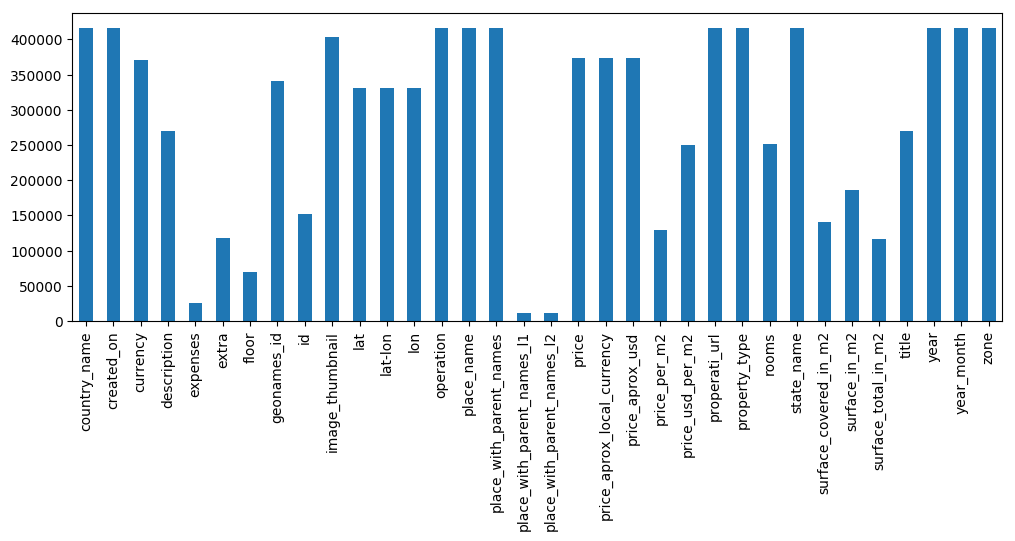

In [16]:
sell_properati.count().plot(kind='bar')

In [17]:
sell_properati[(pd.isnull(sell_properati['place_name']))].zone.unique()

array(['Tigre'], dtype=object)

#### Las propiedades del tigre son las unicas que no contienen informacion en 'place_name'

In [18]:
sell_properati.loc[pd.isnull(sell_properati['place_name']),'place_name'] = sell_properati.place_name.apply(lambda x : x if pd.notnull(x) else 'Tigre' )

In [19]:
sell_properati[(pd.isnull(sell_properati['place_name']))].zone.unique()

array([], dtype=object)

In [20]:
sell_properati.shape

(416685, 34)

In [21]:
sell_properati.groupby(by='id').count().shape

(136840, 33)

sell_properati.drop(inplace=True,labels=['id','operation','country_name','properati_url','description','image_thumbnail','title'],axis=1)

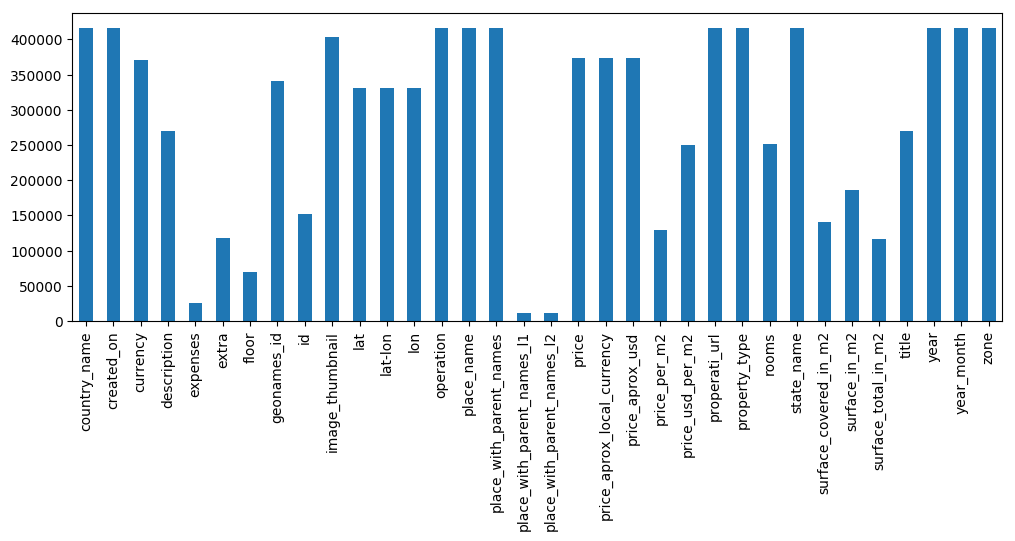

In [22]:
sell_properati.count().plot.bar()

In [23]:

sell_properati.property_type.unique()


array(['house', 'apartment', 'store', 'PH'], dtype=object)

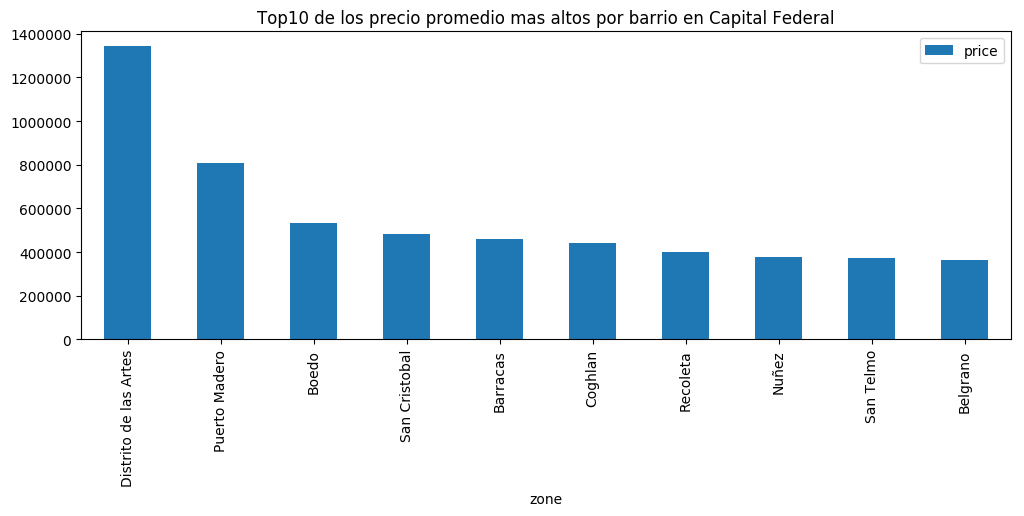

In [24]:
sell_properati[   (sell_properati['property_type'] == 'apartment') & \
                  (sell_properati['state_name'] == 'Capital Federal' )
              ].groupby(by='zone').mean()\
                .reset_index().sort_values(by='price',ascending=False).head(10)\
                .plot.bar(y='price',x='zone',title='Top10 de los precio promedio mas altos por barrio en Capital Federal')

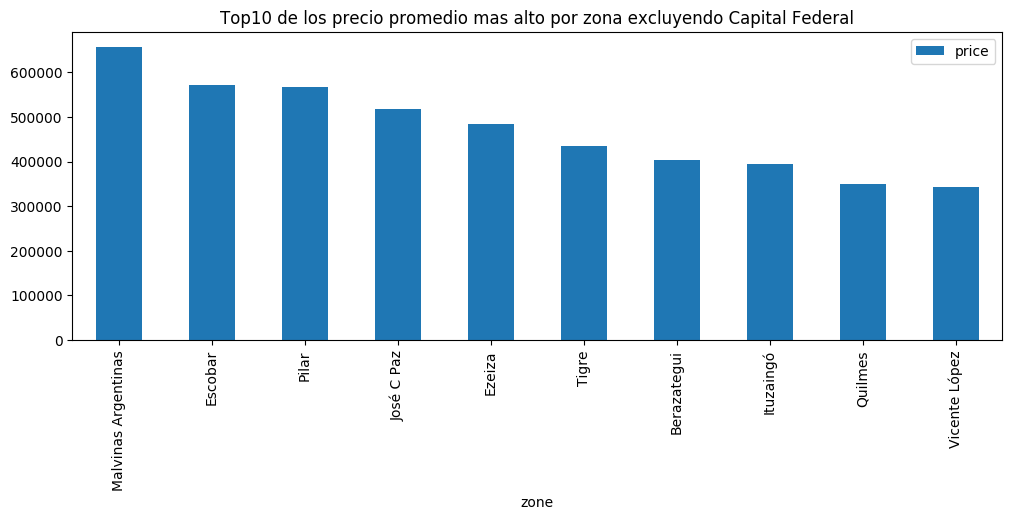

In [25]:
sell_properati[   (sell_properati['property_type'] == 'apartment') & \
                  (sell_properati['state_name'] != 'Capital Federal' )
              ].groupby(by='zone').mean()\
                .reset_index().sort_values(by='price',ascending=False).head(10)\
                .plot.bar(y='price',x='zone',title='Top10 de los precio promedio mas alto por zona excluyendo Capital Federal')

### A continuacion vamos a trabajar con los precios de las propiedades

In [26]:
price_sell_properati = sell_properati[['place_name','property_type','currency','price','price_aprox_local_currency','price_aprox_usd',\
                                       'surface_total_in_m2','surface_covered_in_m2','price_per_m2','price_usd_per_m2']]

In [27]:
price_sell_properati.shape

(416685, 10)

In [28]:
price_sell_properati.count()

place_name                    416685
property_type                 416685
currency                      370387
price                         373561
price_aprox_local_currency    373559
price_aprox_usd               373559
surface_total_in_m2           115950
surface_covered_in_m2         141163
price_per_m2                  128652
price_usd_per_m2              250246
dtype: int64

In [29]:
price_sell_properati[pd.isnull(price_sell_properati['currency'])].sample(5)

,place_name,property_type,currency,price,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_per_m2,price_usd_per_m2
530855,Lanús Este,house,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
504111,Palermo Soho,apartment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
403129,La Matanza,house,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
285704,Haras del Sur IV,apartment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103577,Avellaneda,apartment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
price_sell_properati[pd.isnull(price_sell_properati['currency'])].count()

place_name                    46298
property_type                 46298
currency                          0
price                          3174
price_aprox_local_currency     3174
price_aprox_usd                3174
surface_total_in_m2           10018
surface_covered_in_m2         10043
price_per_m2                      0
price_usd_per_m2                 12
dtype: int64

Debemos excluir los datos que tienen no tienen datos sobre 'currency' ya que no nos brindan ninguna informacion y ademas afecta el resultado real puesto que no tienen datos sobre el precio y la superficie por lo cual no se pueden sacar muchas conclusiones de esto.

In [31]:
price_sell_properati = price_sell_properati[pd.notnull(price_sell_properati['currency'])]

In [32]:
price_sell_properati[pd.isnull(price_sell_properati['price']) ].shape[0]

0

In [33]:
price_sell_properati[pd.isnull(price_sell_properati['price_aprox_local_currency']) ].shape[0]

2

In [34]:
price_sell_properati[pd.isnull(price_sell_properati['price_aprox_usd']) ].shape[0]

2

In [35]:
price_sell_properati[pd.isnull(price_sell_properati['surface_total_in_m2']) ].shape[0]

264455

In [36]:
price_sell_properati[pd.isnull(price_sell_properati['surface_covered_in_m2']) ].shape[0]

239267

In [37]:
price_sell_properati[pd.isnull(price_sell_properati['price_per_m2']) ].shape[0]

241735

In [38]:
price_sell_properati[pd.isnull(price_sell_properati['price_usd_per_m2']) ].shape[0]

120153

In [39]:
price_sell_properati[pd.isnull(price_sell_properati['price_per_m2']) ].groupby(by='currency').count()

,place_name,property_type,price,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_per_m2,price_usd_per_m2
currency,,,,,,,,,
ARS,23659,23659,23659,23657,23657,523,47,0,16287
BRL,2,2,2,2,2,0,0,0,0
PEN,2,2,2,2,2,0,0,0,0
USD,218072,218072,218072,218072,218072,6580,2421,0,140446


In [40]:
price_sell_properati.groupby(by='currency').count()

,place_name,property_type,price,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_per_m2,price_usd_per_m2
currency,,,,,,,,,
ARS,28719,28719,28719,28717,28717,4295,5107,5060,19985
BRL,2,2,2,2,2,0,0,0,0
PEN,2,2,2,2,2,0,0,0,0
USD,341664,341664,341664,341664,341664,101637,126013,123592,230249


 Queremos estudiar el precio en dolares de los inmuebles por lo cual la informacion que mas nos interesa es **price, price_aprox_usd, price_per_m2, surface_total_in_m2 y price_usd_por_m2 **, teniendo en cuenta estas 5 columna se podria completar gran parte de los datos para tener la mayor presicion posible al realizar el analisis exploratorio. 

Se van a estimar los datos de los precios publicados en [PEN](https://es.wikipedia.org/w/index.php?title=Nuevo_sol) ya que no aportan informacion sobre los metros cuadrados de las propiedades

In [41]:
price_sell_properati = price_sell_properati[(price_sell_properati['currency'] == 'ARS') | (price_sell_properati['currency'] == 'USD') ]

In [42]:
price_sell_properati.count()

place_name                    370383
property_type                 370383
currency                      370383
price                         370383
price_aprox_local_currency    370381
price_aprox_usd               370381
surface_total_in_m2           105932
surface_covered_in_m2         131120
price_per_m2                  128652
price_usd_per_m2              250234
dtype: int64

In [43]:
def dataframe_calc_value(df,incognita,divisor,dividendo):
    df.loc[ (pd.isnull(df[incognita])) |  (df[incognita] == 0 ) & (pd.notnull(df[divisor]) ) & (df[divisor] > 0) & \
            (pd.notnull(df[dividendo]) & (df[dividendo] > 0)) ,incognita] = \
    df.loc[ (pd.isnull(df[incognita])) |  (df[incognita] == 0 ) & (pd.notnull(df[divisor]) ) & (df[divisor] > 0) & \
            (pd.notnull(df[dividendo]) & (df[dividendo] > 0))][divisor] / \
    df.loc[ (pd.isnull(df[incognita])) |  (df[incognita] == 0 ) & (pd.notnull(df[divisor]) ) & (df[divisor] > 0) & \
            (pd.notnull(df[dividendo]) & (df[dividendo] > 0))][dividendo]

### Se agrega la superficoe total de los inmbuebles que disponen del precio por metro cuadrado en dolares

In [44]:
dataframe_calc_value(price_sell_properati,'surface_total_in_m2','price_aprox_usd','price_usd_per_m2')

### Calculamos la superficie total en metros cuadrados de las propiedades que no cuentan con este dato

In [45]:
dataframe_calc_value(price_sell_properati,'surface_total_in_m2','price','price_per_m2')

### Calculamos el precio por metro cuadrado en USD de los inmuebles que no cuentan con dicha informacion

In [46]:
dataframe_calc_value(price_sell_properati,'price_usd_per_m2','price_aprox_usd','surface_total_in_m2')

### Se agrega el precio por metro cuadrado en la moneda actual en cada unos de las pripiedades

In [47]:
dataframe_calc_value(price_sell_properati,'price_per_m2','price','surface_total_in_m2')

In [48]:
price_sell_properati.count()

place_name                    370383
property_type                 370383
currency                      370383
price                         370383
price_aprox_local_currency    370381
price_aprox_usd               370381
surface_total_in_m2           287289
surface_covered_in_m2         131120
price_per_m2                  287277
price_usd_per_m2              287277
dtype: int64

In [49]:
price_sell_properati = price_sell_properati[~((price_sell_properati['surface_total_in_m2'] == 0 ) | \
                     (price_sell_properati['price'] == 0 ))]

In [50]:
price_sell_properati.count()

place_name                    368278
property_type                 368278
currency                      368278
price                         368278
price_aprox_local_currency    368276
price_aprox_usd               368276
surface_total_in_m2           285384
surface_covered_in_m2         129771
price_per_m2                  285384
price_usd_per_m2              285384
dtype: int64

Ahora contamos con la informacion mucho mas completa para poder realizar un analisis exploratorio mas preciso

### ¿Que tipo de propiedades son las que no tienen informacion sobre los metros cuadrados cubiertos?

In [51]:
price_sell_properati[pd.isnull(price_sell_properati['surface_covered_in_m2'])].groupby(by='property_type').count()

,place_name,currency,price,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_per_m2,price_usd_per_m2
property_type,,,,,,,,,
PH,15299,15299,15299,15299,15299,9761,0,9761,9761
apartment,148529,148529,148529,148527,148527,96370,0,96370,96370
house,71278,71278,71278,71278,71278,47912,0,47912,47912
store,3401,3401,3401,3401,3401,1571,0,1571,1571


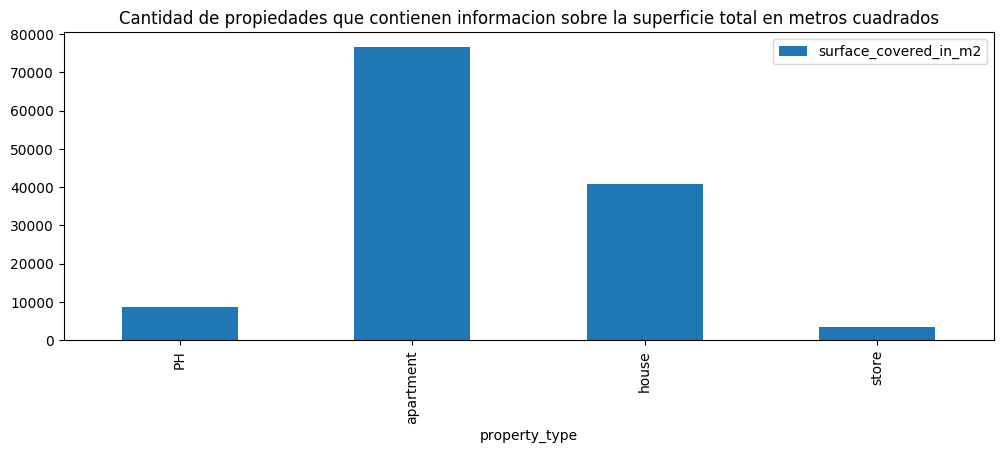

In [52]:
price_sell_properati.groupby(by='property_type').count().reset_index()\
            .plot.bar(x='property_type',y='surface_covered_in_m2'\
            ,title='Cantidad de propiedades que contienen informacion sobre la superficie total en metros cuadrados')

###### Hay todo tipo de propiedades que no cuentan con la informacion de los metros cuadrados cubiertos, por lo cual no podemos sacar ninguna informacion reelevante. 

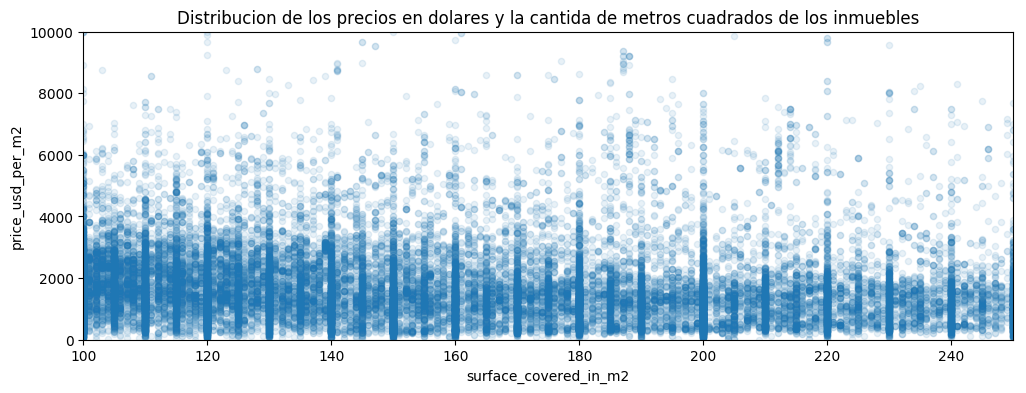

In [53]:
ax = plt.subplot(111)
ax.set_xlim(100,250)
ax.set_ylim(0,10000)
price_sell_properati[price_sell_properati['surface_covered_in_m2'] >0]\
                .plot.scatter(alpha=0.1,x='surface_covered_in_m2',y='price_usd_per_m2',ax=ax,\
                title='Distribucion de los precios en dolares y la cantida de metros cuadrados de los inmuebles')


sell_properati

Falta completar los siguientes codigos


### Se agrega la superficoe total de los inmbuebles que disponen del precio por metro cuadrado en dolares


In [54]:
sell_properati_filter = sell_properati

In [55]:
sell_properati_filter[['surface_total_in_m2','price_usd_per_m2','price_per_m2','price_aprox_usd','price']].count()

surface_total_in_m2    115950
price_usd_per_m2       250246
price_per_m2           128652
price_aprox_usd        373559
price                  373561
dtype: int64

In [56]:
dataframe_calc_value(sell_properati_filter,'surface_total_in_m2','price_aprox_usd','price_usd_per_m2')

### Calculamos la superficie total en metros cuadrados de las propiedades que no cuentan con este dato

In [57]:
dataframe_calc_value(sell_properati_filter,'surface_total_in_m2','price','price_per_m2')

### Calculamos el precio por metro cuadrado en USD de los inmuebles que no cuentan con dicha informacion

In [58]:
dataframe_calc_value(sell_properati_filter,'price_usd_per_m2','price_aprox_usd','surface_total_in_m2')

### Se agrega el precio por metro cuadrado en la moneda actual en cada unos de las pripiedades

In [59]:
dataframe_calc_value(sell_properati_filter,'price_per_m2','price','surface_total_in_m2')

In [60]:
sell_properati_filter[['surface_total_in_m2','price_usd_per_m2','price_per_m2']].mean()

surface_total_in_m2    6942.511609
price_usd_per_m2               inf
price_per_m2                   inf
dtype: float64

In [61]:
sell_properati_filter = sell_properati_filter[~((sell_properati['surface_total_in_m2'] == 0 ) | \
                     (sell_properati['price'] == 0 ))]

Lista de pendiente

Agregar informacion sobre el transporte y visualizar cual es la influencia de estos en el precio, teniendo en cuenta la distancia

Agregar informacion sobre los espacios verdes y visualizar el efecto de estos en el precio de las propiedades

In [62]:
sell_properati_filter[['surface_total_in_m2','price_usd_per_m2','price_per_m2','price_aprox_usd','price']].describe()

,surface_total_in_m2,price_usd_per_m2,price_per_m2,price_aprox_usd,price
count,2.932440e+05,2.853920e+05,2.853840e+05,3.682800e+05,3.682820e+05
mean,7.037485e+03,2.265164e+03,3.858673e+03,2.328288e+05,3.189323e+05
std,3.693307e+06,9.868284e+03,1.705170e+04,3.492775e+05,7.118130e+05
min,1.000000e+00,5.000000e-05,5.000000e-05,4.699600e+03,2.000000e+02
25%,5.000000e+01,1.203704e+03,1.381215e+03,9.400000e+04,9.850000e+04
50%,8.200000e+01,1.835000e+03,1.980099e+03,1.476520e+05,1.650000e+05
75%,2.000000e+02,2.447368e+03,2.741504e+03,2.600000e+05,3.250000e+05
max,2.000000e+09,2.600000e+06,6.172050e+06,5.000000e+07,1.484420e+08


In [63]:
estimate_dollar_price = sell_properati_filter[sell_properati_filter['currency'] == 'ARS'].groupby(by='year_month').mean().reset_index()

In [64]:
estimate_dollar_price = estimate_dollar_price[(estimate_dollar_price['price_usd_per_m2'] > 0)]

In [65]:
estimate_dollar_price = estimate_dollar_price[(estimate_dollar_price['price_per_m2'] > 0)]

In [66]:
estimate_dollar_price['dolar'] = estimate_dollar_price['price_per_m2'] / estimate_dollar_price['price_usd_per_m2']

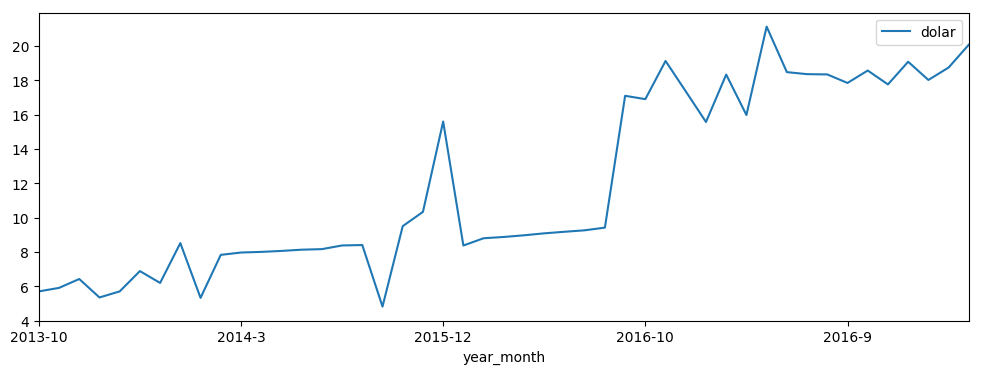

In [68]:
estimate_dollar_price.plot.line(x='year_month',y='dolar')

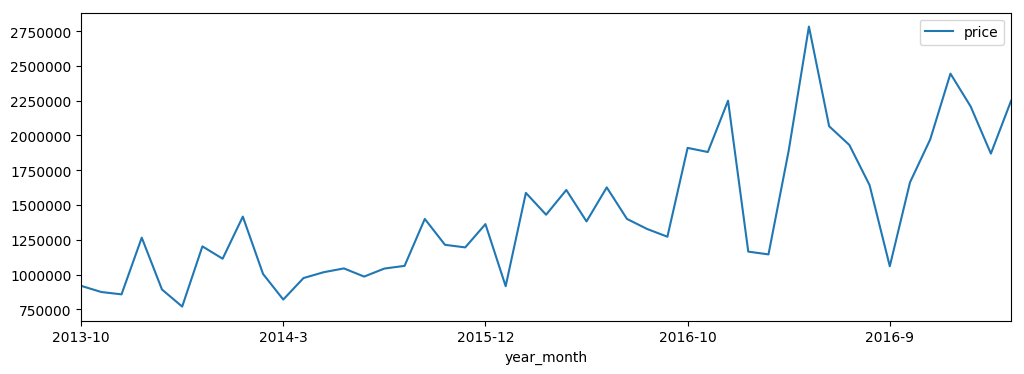

In [114]:
estimate_dollar_price.plot.line(x='year_month',y='price')

In [101]:
import statsmodels.api as sm 


In [132]:
df = estimate_dollar_price

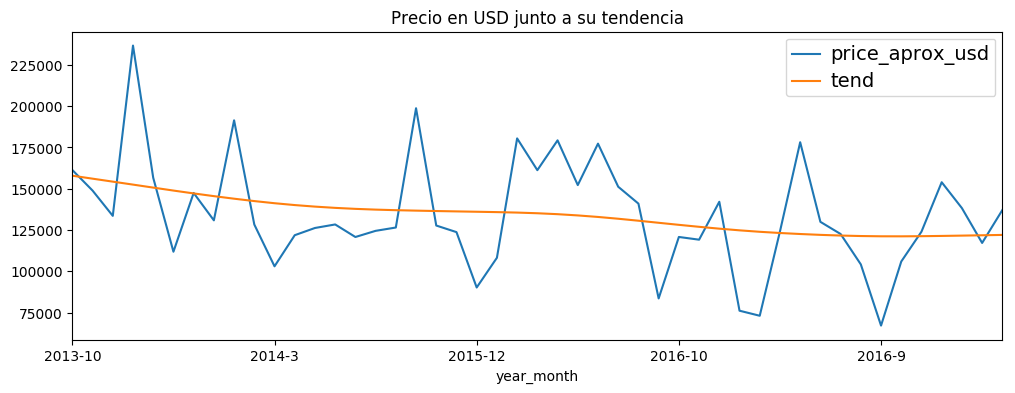

In [133]:
# Aplicando el filtro Hodrick-Prescott para separar en tendencia y 
# componente ciclico.
price_aprox_usd, price_aprox_usd_tend = sm.tsa.filters.hpfilter(df['price_aprox_usd'])
df['tend'] = price_aprox_usd_tend

# graficando la variacion del precio real con la tendencia.
df.plot(x='year_month',y=['price_aprox_usd','tend'],title='Precio en USD junto a su tendencia');
legend = plt.legend()
legend.prop.set_size(14);



#### Curiosamente se puede ver como los precios de las propiedades se mantienen a lo largo de estos ultimos años, con una leve tendencia hacia la baja de los precios

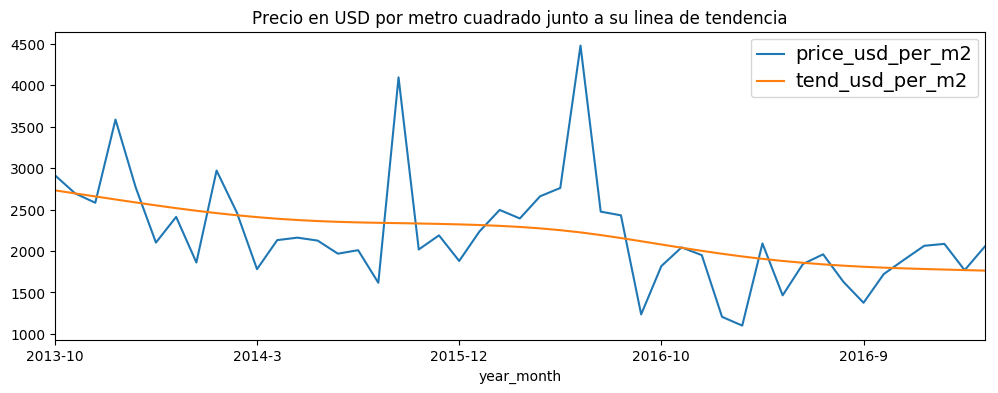

In [125]:
# Aplicando el filtro Hodrick-Prescott para separar en tendencia y 
# componente ciclico.
price_usd_per_m2, pride_usd_per_m2_tend = sm.tsa.filters.hpfilter(df['price_usd_per_m2'])
df['tend_usd_per_m2'] = pride_usd_per_m2_tend

# graficando la variacion del precio real con la tendencia.
df.plot(x='year_month',y=['price_usd_per_m2','tend_usd_per_m2'],title='Precio en USD por metro cuadrado junto a su linea de tendencia');
legend = plt.legend()
legend.prop.set_size(14);



Tanto el precio en USD por metro cuadrado, como por propiedad va bajando a medida que pasa el tiempo, ¿que es lo que pasa con el precio en ARS?

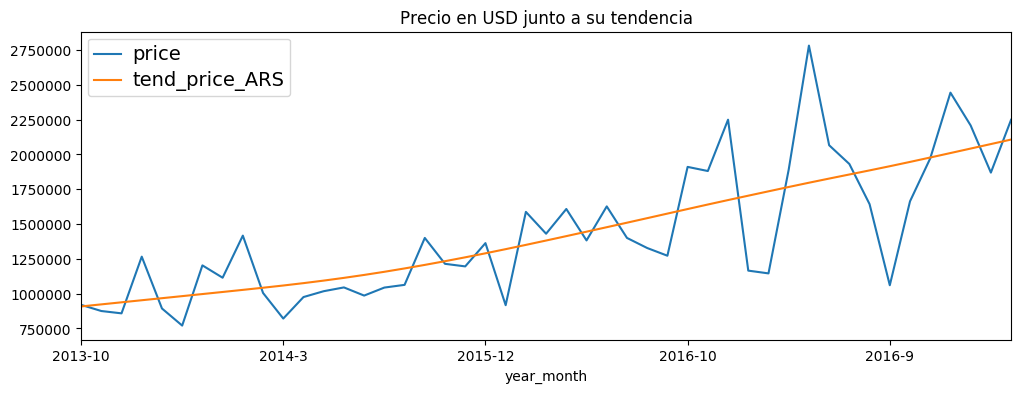

In [134]:
# Aplicando el filtro Hodrick-Prescott para separar en tendencia y 
# componente ciclico.
price, tend_price_ARS = sm.tsa.filters.hpfilter(df['price'])
df['tend_price_ARS'] = tend_price_ARS

# graficando la variacion del precio real con la tendencia.
df.plot(x='year_month',y=['price','tend_price_ARS'],title='Precio en USD junto a su tendencia');
legend = plt.legend()
legend.prop.set_size(14);



In [82]:
sell_properati_filter.price_aprox_usd.min()

4699.6000000000004

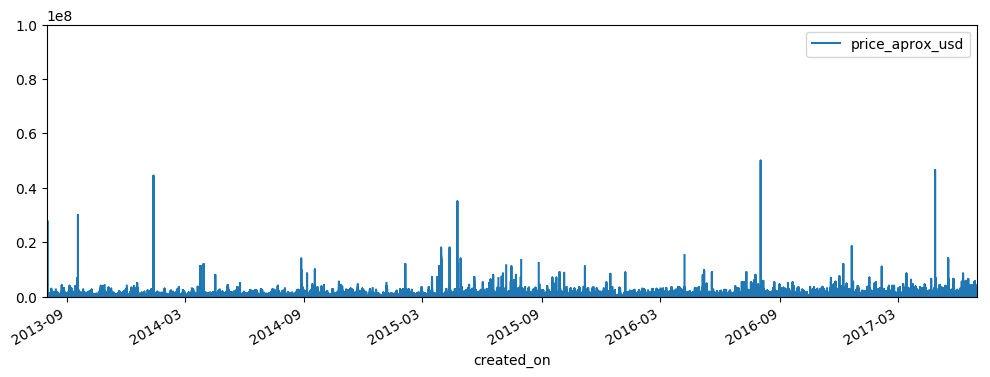

In [84]:
ax = plt.subplot(111)
ax.set_xlim(0,250)
ax.set_ylim(4600,100000000)

sell_properati_filter.plot.line(x='created_on',y='price_aprox_usd',ax=ax)

In [ ]:
sell_properati[sell_properati['property_type'] == 'apartment']\
.plot.bar(x='rooms',y='price_usd_per_m2',title='Precio del metro cuadrado en dolares promedio, de los departamentos segun la cantidad de ambintes')

In [ ]:
sell_properati[sell_properati['property_type'] == 'house'].groupby(by='rooms').std().reset_index()\
.plot.bar(x='rooms',y='price_usd_per_m2',title='Precio del metro cuadrado en dolares promedio de las casas segun la cantidad de ambientes')

In [ ]:
sell_properati[sell_properati['property_type'] == 'apartment'].groupby(by='floor').mean().reset_index()\
.plot.bar(x='floor',y='price_usd_per_m2',title='Precio promedio de un departamento segun el piso en el cual se encuentra')

Esta imagen muestra la anomalia en cuanto al piso en el cual se encuentra un departamento, por lo cual se decidio ver mas en profundidad cuales son los numeros de habitaciones que hay en este set de datos

In [ ]:
sell_properati[sell_properati['property_type'] == 'apartment'].floor.describe()

In [ ]:
sell_properati[sell_properati['property_type'] == 'apartment'].floor.unique().astype(int)

Como se puede ver, es muy extraño este patron ya que hay "aparment" que se encuentran en el piso 2509 lo cual implica que haya algun edificio con esa cantidad de pisos en la ciudad o el gran buenos aires.